# Encoding and Decoding 
## COGS 138 - Final Project
#### Tayler Shaw, Aliya Paracha, Aaron Smith, Andrew Hernandez

## Overview
This project explored ways to be able to train a model to detect whether a person had attended to an aversive visual stimulus. In this project we attempt to extract feature of a spike related to an aversive stimulus using fft and welches methods. We attempted to quantify the relationship between the number of spike times and when a aversive stimulus was presented. We used Logistic Regression and Randome Forrest to train a model to detect whether or not a spike time occurs. 

### Imports

In [367]:
import h5py
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from h5py import Group

from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal
import numpy as np

from sklearn.model_selection import train_test_split
# the paper uses 1024 trees, & the size of the feature set considered for each 
# split is 1,2,4,5,8,12,16, & 20. 
from sklearn.ensemble import RandomForestClassifier

# Import library for our grid search
from sklearn.model_selection import GridSearchCV
#Import library for evalating the model 
from sklearn import metrics

## Introduction

The main motivation behind our project was to examine if by leveraging the dataset of human amygdala single-neuron recordings, we could predict whether the person was shown a neutral, or aversive, visual stimulus?

Currently in the field a big part of understanding sensory neuroscience is to firstly analyze how the outside information is received by the brain results in patterns of signals in the brain, and then how can those patterns elaborate on the perception.  In the study titled, Dataset of spiking and LFP activity invasively recorded in the human amygdala during aversive dynamic stimuli, dataset of 9 subjects who were diagnosed with epilepsy and had undergone preoperative invasive monitoring in the mesial temporal lobe, was provided. In accordance to the data, each subject had different neuronal spike times and waveforms, when introduced to the aversive vs neutral stimuli. Therefore, after attaining knowledge on the different models used in the field of  Cognitive Electrophysiology for encoding and decoding, through a paper called Encoding and Decoding Models in Cognitive Electrophysiology, by Holdgraf, Christopher R. et al. we decided to use the dataset to decode the eeg signals and determine or rather predict the perception of visual stimulus in the 9 subjects.

Additionally other work done previously in line with the motivation behind our hypothesis was by O. Bazgir, Z. Mohammadi and S. A. H. Habibi.  Researchers, in the paper, Emotion Recognition with Machine Learning Using EEG Signals, also probed the question of whether emotional states could be predicted using the dataset  provided. The study used machine learning algorithm models like Support vector machine (SVM), K-nearest neighbor (KNN) and artificial neural network (ANN) to classify the different emotional states.



## Background Information & Helpful Links


###### Infomation on Modeling
Holdgraf & et al. paper.  

https://www.frontiersin.org/articles/10.3389/fnsys.2017.00061/full

###### Dataset Background Information

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7809031/

##### Download the dataset 

G-node.org:

https://doi.gin.g-node.org/10.12751/g-node.270z59/

Personal Google Drive:

https://drive.google.com/drive/folders/1YSRA4gXxbHIzbIhokkzNPwBltfAgaH2f?usp=sharing

## SUBJECTS INFO

#### Description
The dataset used was collected from the amygdalae of nine subjects. They were given visual cues of emotionally aversive or neutral content while taking a recording of their electrophysiological responses. The subjects wer presented with either an aversive stimulus such as sequences of fearful faces or neutral sequences such as landscapes. 

This dataset also contain the neuronal spike times the iEEG recording, and the waveforms.

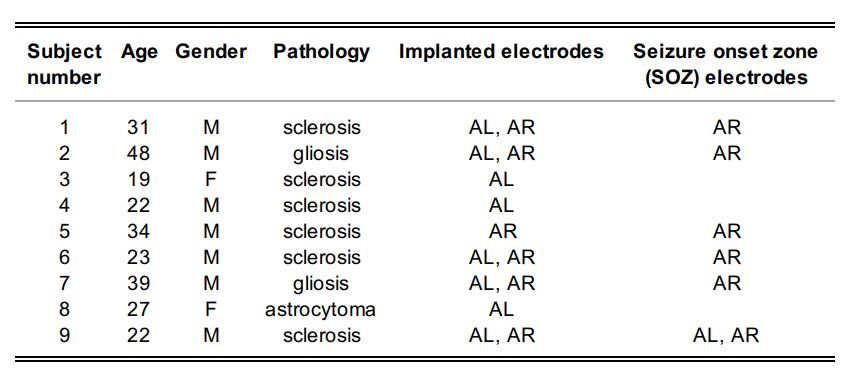

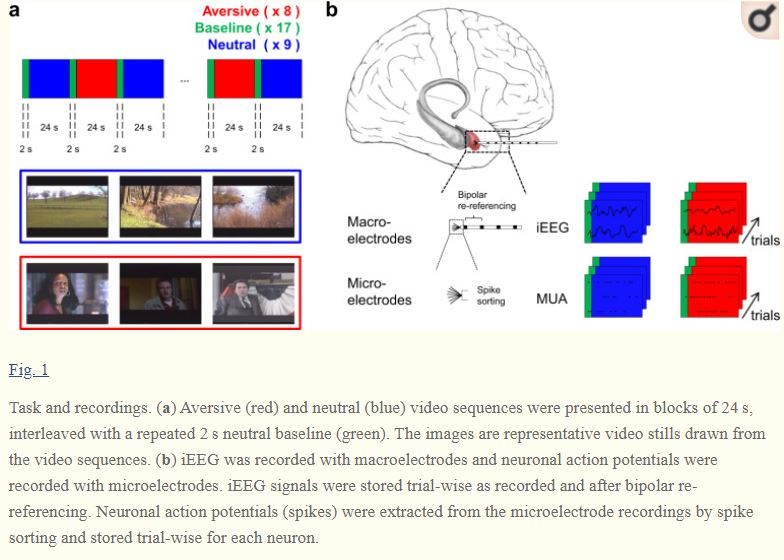

fig1 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7809031/)

In [368]:
# create an Empty DataFrame object 
data = pd.DataFrame() 
subject_Age = [31,48,19,22,34,23,39,27,22]
subject_Gender = [1,1,0,1,1,1,1,0,1]
subject_Electrodes = [['AL','AR'],['AL','AR'],['AL'],['AL'],['AR'],['AL','AR'],['AL','AR'],['AL'],['AL','AR']]
subject_Pathology = ['sclerosis','gliosis','sclerosis','sclerosis','sclerosis','sclerosis','gliosis','astrocytoma','sclerosis']
subject_siezureZone = [['AR'],['AR'],['none'],['none'],['AR'],['AR'],['AR'],['none'],['AL','AR']]
data["Age"] = subject_Age
data["Gender"] = subject_Gender
data["Pathology"] = subject_Pathology
data["Implanted Electrodes"] = subject_Electrodes
data["Siezure Onset Zone"] = subject_siezureZone
data

,Age,Gender,Pathology,Implanted Electrodes,Siezure Onset Zone
0,31,1,sclerosis,"[AL, AR]",[AR]
1,48,1,gliosis,"[AL, AR]",[AR]
2,19,0,sclerosis,[AL],[none]
3,22,1,sclerosis,[AL],[none]
4,34,1,sclerosis,[AR],[AR]
5,23,1,sclerosis,"[AL, AR]",[AR]
6,39,1,gliosis,"[AL, AR]",[AR]
7,27,0,astrocytoma,[AL],[none]
8,22,1,sclerosis,"[AL, AR]","[AL, AR]"


##### Recordings

Sampling frequency of 4 kHz for the macroelectrodes and 32 kHz for the microelectrodes via the ATLAS recording system (0.5–5000 Hz

 iEEG data were resampled at 2 kHz.” In the presented dataset, we share epoched iEEG data (trials of 26 seconds)

In [369]:
fs_macroelectrodes = 4*1000
fs_microelectrodes = 32*1000
fs_iEEG = 2*1000
dt = 26

#### More Information

For more information on the subject data see this google drive here 

Google Drive
https://drive.google.com/drive/folders/1FW1eMtkcOpRsE3Pk_5svNhImD_yj2g7_?usp=sharing

In [370]:
data_dir = "./data_NIX/"

### Helper Function to unpack the data from the H5 file

In [371]:
def unpack_data(h5):

    h5 = h5py.File(h5, 'r')

    data_dict = {}

    subj = list(h5['data'].keys())[0]
    data_arrays = h5['data'][subj]['data_arrays']

    for key in data_arrays.keys():

            if isinstance(data_arrays[key]['data'], h5py._hl.dataset.Dataset):

                data_dict[key] =  np.array(data_arrays[key]['data'])

    return data_dict

##### This is all of the metadata for each subject now unpacked

In [372]:
subject1 = unpack_data('data_NIX/Data_Subject_01_Session_01.h5')
subject2 = unpack_data('data_NIX/Data_Subject_02_Session_01.h5')
subject3 = unpack_data('data_NIX/Data_Subject_03_Session_01.h5')
subject4 = unpack_data('data_NIX/Data_Subject_04_Session_01.h5')
subject5 = unpack_data('data_NIX/Data_Subject_05_Session_01.h5')
subject6 = unpack_data('data_NIX/Data_Subject_06_Session_01.h5')
subject7 = unpack_data('data_NIX/Data_Subject_07_Session_01.h5')
subject8 = unpack_data('data_NIX/Data_Subject_08_Session_01.h5')
subject9 = unpack_data('data_NIX/Data_Subject_09_Session_01.h5')

### Helper Functions for Pulling the Data

I created these helper functions to extract certain information that I may have wanted to use for analysis of the data.

In [373]:
# This give you the list of the ket from the subject data
def key_list(subject_data):
    key_list = list(subject_data.keys())
    return key_list

In [374]:
# key_list(subject1)

In [375]:
def get_key(subject_data,key_index):
    keys_list = list(subject_data)
    key = keys_list[key_index]
    return key    

In [376]:
#get_key(subject1,0)

In [377]:
# Helper function returns list data by index keys
def get_data(subject_data,key_index):
    keys_list = list(subject_data)
    key = keys_list[key_index]
    data = list(subject_data[key])
    return data

In [378]:
#get_data(subject1,0)

In [379]:
def create_df(subject_data,key_index):
    key = get_key(subject_data,key_index)
    data = get_data(subject_data,key_index)
    df = pd.DataFrame(data,columns = [key])
    return df

In [380]:
#create_df(subject1,0)

In [381]:
# All of the data for every subject data have the iEEG data, this creates a dataframes of that data when called 
def get_df(subject_data,start,num_trials):
    df = pd.DataFrame()
    j = start
    for i in range(num_trials):    
        df[get_key(subject_data,j)] = get_data(subject_data,j)
        j += 1
    return df

In [382]:
#get_df(subject1,0,17)

In [383]:
# For each subject there is a different number of trials, the pattern of how the stimulus was shown was always
# presented in this way. This function creates a list of trials to help with later seperating neutral versus aversive

def neutral_aversive(units):
    n = 1
    a = 0
    list_stimulus_types = [n,a,n,a,n,a,n,a,n,a,n,a,n,a,n,a,n]*units
    return list_stimulus_types

In [384]:
# For instance subject 1 has 17 trials of 4 units, therefor this is the list to distinguish all the aversive and neutral 

#neutral_aversive(4)

Checking the length of the key list inside each subject to see how they compare

In [385]:
# Here I just wanted to see the length of the keys in each subject 
size1 = len(key_list(subject1))
size2 = len(key_list(subject2))
size3 = len(key_list(subject3))
size4 = len(key_list(subject4))
size5 = len(key_list(subject5))
size6 = len(key_list(subject6))
size7 = len(key_list(subject7))
size8 = len(key_list(subject8))
size9 = len(key_list(subject9))
sizes = [size1,size2,size3,size4,size5,size6,size7,size8,size9]
print(sizes)

[91, 235, 73, 145, 19, 19, 307, 19, 19]


So now its obvious that this data is not consistent across the different subjects so now I want to look through each subject and see which one actually have the full dataset that we can you to do further analysis. 

### Exploring the Trials

In [386]:
#All of the Trial Data are time stamps of when the spike times occured, 
# starting at -2 seconds [baseline ]and going up to nearly 24 seconds[stimulus time], 

#This is the data for 'Spike_Times_Unit_1_uAL_1_Trial_16'
subject1[get_key(subject1,32)]

array([-0.41282   , -0.4051325 , -0.26216375,  0.04602375,  0.20864875,
        0.220055  ,  1.3064925 ,  4.51502175,  5.033678  ,  5.04033425,
        5.049053  ,  5.40839675,  6.95608325,  6.974427  ,  8.3137395 ,
       10.08183225, 10.75064475, 10.7563635 , 13.51958125, 13.52489375,
       16.521299  , 19.970422  , 20.94870325, 20.95576575])

In [387]:
#This calculates when the spike time ended for each trial

#This creates a list of all the last time stamps from every trial
time_samples_end = []
for i in range(67):
    time_samples_end.append(subject1[get_key(subject1,17+i)][-1])

#See when all the trials ended
print("The average last time when spike occured = ",np.mean(time_samples_end))

The average last time when spike occured =  22.89753258955178


In [388]:
# How many last spike times were less than 22 seconds

#This looks at how many time counts were less than 22 secs, in this cas there was 11 trials thats went less than 22 sec
values = []
false_time = 0
for i in range(len(time_samples_end)):
    if time_samples_end[i] > 22:
        values.append(True)
    else:
        values.append(False)
        false_time+=1
        
print("The number of last spike time occuring less than 22 seconds = ",false_time)

The number of last spike time occuring less than 22 seconds =  11


In [389]:
# This is the maximum number and the minimim number of spike times in  given trial
time_samples = []
for i in range(67):
    for j in range(len(subject1[get_key(subject1,17+i)])):
        time_samples.append(len(subject1[get_key(subject1,17+i)]))
    
print("Mean # of spikes over all trials = ",np.mean(time_samples))
print("Max # of spikes in a single trial = ",np.max(time_samples))
print("Min # of spikes in a single trial = ",np.min(time_samples))
#time_samples

Mean # of spikes over all trials =  54.38643067846608
Max # of spikes in a single trial =  140
Min # of spikes in a single trial =  8


In [390]:
# Count of total spikes across all trials for both before (base) stimulus and after (stim) 
n_a_list = neutral_aversive(4)
na_list = {'neutral_aversive':n_a_list}
subject1_stim_df = pd.DataFrame(data = na_list)

count_stim = []
count_base = []
#trials * unit 
for j in range(17*4):
    #stim
    count_stim.append(len([i for i in subject1[get_key(subject1,17+j)] if i > 0]))
    #base
    count_base.append(len([i for i in subject1[get_key(subject1,17+j)] if i < 0]))

    
print("The total count in spike times during stimulus = ",sum(count_stim))
print("The total count in spikes times before stimulus = ",sum(count_base))

The total count in spike times during stimulus =  2603
The total count in spikes times before stimulus =  189


## Counting Spike Times 

### function to count spike counts

In [391]:
# Function to get spike counts for any subject 
def spike_count_df(data,num_units):
    # Count of total spikes across all trials for both before (base) stimulus and after (stim) 

    count_stim = []
    count_base = []
    #trials * unit 
    for j in range(17*num_units):
        #stim
        count_stim.append(len([i for i in data[get_key(data,17+j)] if i > 0]))
        #base
        count_base.append(len([i for i in data[get_key(data,17+j)] if i < 0]))

    # Datafram of spikes times per trial for each unit for both before (base) stimulus and after (stim) 
#     data['count_stim'] = 
#     data['count_base'] = count_base
#     data['neutral_aversive'] = neutral_aversive(num_units)
    d = {'count_stim': count_stim, 'count_base': count_base, 'neutral_aversive': neutral_aversive(num_units)}
    df = pd.DataFrame(data=d)
    return df

In [392]:
# Datafram of spikes times per trial for each unit for both before (base) stimulus and after (stim) 
subject1_stim_df['count_stim'] = count_stim
subject1_stim_df['count_base'] = count_base
stim_count = subject1_stim_df['count_stim'].sum()
base_count = subject1_stim_df['count_base'].sum()
print("The total count in spike times during stimulus = ",stim_count)
print("The total count in spikes times before stimulus = ",base_count)
subject1_stim_df

The total count in spike times during stimulus =  2603
The total count in spikes times before stimulus =  189


,neutral_aversive,count_stim,count_base
0,1,37,10
1,0,9,0
2,1,50,1
3,0,18,4
4,1,50,5
...,...,...,...
63,1,57,3
64,0,64,4
65,1,93,3
66,0,75,2


In [393]:
# Counting the neutral stimulus spike times
subject1_stim_neutral = subject1_stim_df[subject1_stim_df['neutral_aversive'] == 1]
total_spike_neutral = sum(subject1_stim_neutral["count_stim"])
spike_average_neutral = total_spike_neutral / len(subject1_stim_neutral)
print("Number of Neutral Spikes : ",total_spike_neutral)
print("Number of Neutral Stimulus : ",len(subject1_stim_neutral))
print("Average of Neutral Stimulus per Trial: ",spike_average_neutral)
subject1_stim_neutral.head()

Number of Neutral Spikes :  1464
Number of Neutral Stimulus :  36
Average of Neutral Stimulus per Trial:  40.666666666666664


,neutral_aversive,count_stim,count_base
0,1,37,10
2,1,50,1
4,1,50,5
6,1,41,1
8,1,39,1


In [394]:
# Counting the aversive stimulus spike times
subject1_stim_aversive = subject1_stim_df[subject1_stim_df['neutral_aversive'] == 0]
total_spike_aversive = sum(subject1_stim_aversive["count_stim"])
spike_average_aversive = total_spike_aversive / len(subject1_stim_aversive)
print("Number of Aversive Spikes : " + str(total_spike_aversive))
print("Number of Aversive Stimulus : " + str(len(subject1_stim_aversive)))
print("Average of Aversive Stimulus per Trial: " + str(spike_average_aversive))
subject1_stim_aversive.head()

Number of Aversive Spikes : 1139
Number of Aversive Stimulus : 32
Average of Aversive Stimulus per Trial: 35.59375


,neutral_aversive,count_stim,count_base
1,0,9,0
3,0,18,4
5,0,33,1
7,0,40,4
9,0,47,5


The results from this method show that the there are more one average spike times for neutral stimulus than for aversive stimulus. This is not what we would expect to see. 

### IV. Approach

##### Exploring the iEEG Data, Trying to Process the Signal to Identify Aversive Spike Times

We have used the dataset which contained the signals from neurons and intracranial EEG recording which came from human amygdala during aversive dynamic visual stimulation. These data sets contain information about the spike times across the trials and whether it was on the left side or the right side of the amygdala. There are labeled cues for whether or the stimulus was aversive or not at the given spiketime. In addition there are spike waveforms data that could be used to help find the pattern of an aversive event occurring. 

In order to make a classification of whether a spike is associated with an aversive or neutral stimulus it may be necessary to isolate the frequency range from which this would occur. Therefore its important to use a band pass filter in order to pass through the known frequency range that the spike is expected to occur. This is why we performed a band pass filter and a fast fourier transform in order to see it there was a spike time that followed along the guidelines given from the spike waveform data. Hopefully we would be able to process the signal in such a way that we would be able to identify the spike. We have graphed what the fft graph looks like in addition to the power spectral density. 


In [395]:
import scipy
from scipy.fft import fft, fftfreq

# Sampling rate for iEEG
fs = fs_iEEG

In [396]:
def bandPassFilter(signal):
    fs = 1000.0
    lowcut = 9.0
    highcut = 20.0
    
    nyq = .5*fs
    low = lowcut / nyq
    high = highcut / nyq
    
    order = 2
    
    b, a = scipy.signal.butter(order,[low,high],'bandpass',analog=False)
    y = scipy.signal.filtfilt(b,a,signal,axis=0)
    return y 

In [397]:
filtered_EEG = bandPassFilter(subject1['iEEG_Data_Trial_01'][0])

In [398]:
def fft_data(data):
    # Number of samples in normalized_tone
    N = len(data)
    yf = fft(data)
    xf = fftfreq(N, 1 / fs)
        
    return xf, yf



def fft_plot(data):
    # Number of samples in normalized_tone
        N = len(data)
        yf = fft(data)
        xf = fftfreq(N, 1 / fs)
        plt.plot(xf, np.abs(yf))
        plt.xlim(0,100)
        plt.show()
        

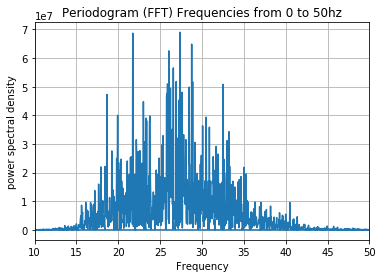

In [399]:
#Periodogram (FFT) Frequencies from 0 to 50hz
power = np.abs(np.fft.fft(filtered_EEG))**2
frequency = np.fft.fftfreq(len(filtered_EEG),1/fs)
plt.plot(frequency,power)
plt.xlabel('Frequency')
plt.ylabel("power spectral density")
plt.title("Periodogram (FFT) Frequencies from 0 to 50hz")
plt.xlim(10,50)
plt.grid()

Doing the Fast Fourier Transform on the signal help us to get the power spectrum of the signal and allows us to see the spikes that would otherwise be lost in the noise. We may be able to use this pull a feature extract of the spike just by the frequency range and shape of the signal. 

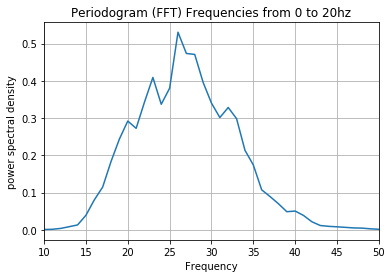

In [400]:
# Periodogram (FFT) Frequencies from 0 to 20hz
f, pxx = scipy.signal.welch(filtered_EEG, fs = fs, scaling = 'spectrum', nperseg = 2000)
plt.plot(f,pxx)
plt.xlabel('Frequency')
plt.ylabel("power spectral density")
plt.title("Periodogram (FFT) Frequencies from 0 to 20hz")
plt.xlim(10,50)
plt.grid()

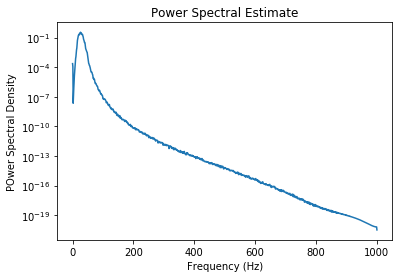

In [401]:
# Power Spectral Estimate
f, pxx = scipy.signal.welch(filtered_EEG, fs = fs, nperseg = 2000)
plt.semilogy(f,pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel("POwer Spectral Density")
plt.title("Power Spectral Estimate")

import warnings
warnings.filterwarnings("ignore")

Welches method may also be useful in feature extraction because we can zoom in on a section of the signal that we may have interest and get a smoother attenuate for a better fit of the intended signal would be. 

#### IV. Approach 

#### Comparing the Graphs to the Spike_Waveform_Unit_1 Given from the Dataset

Inside this data there are two waveforms, ,the second one seems to be the raw spike waveform and the first one seems to be and averages, smoothed out version of the spike form. This is consistent with all Spike Waveform data. This is the averaged spike wavefore of all the 17 trials inside of the uAL. As you can see the fit of our processed single trial does follow the general pattern and we think that applying these methods done on the single trial above could possible be used to identify spike feature in all trials 

#### Spike_Waveform_Unit_1_uAL_1

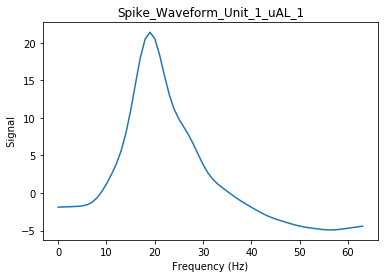

In [415]:
#Smooth Waveform
Spike_Waveform_Unit_1_uAL_1_a = subject1[get_key(subject1,85)][0]
plt.xlabel('Frequency (Hz)')
plt.ylabel(" Signal ")
plt.title("Spike_Waveform_Unit_1_uAL_1")
plt.plot(Spike_Waveform_Unit_1_uAL_1_a)

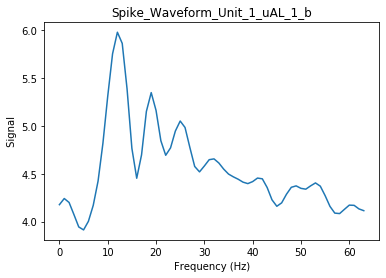

In [416]:
#Raw Waveform 
Spike_Waveform_Unit_1_uAL_1_b = subject1[get_key(subject1,85)][1]
plt.xlabel('Frequency (Hz)')
plt.ylabel(" Signal ")
plt.title("Spike_Waveform_Unit_1_uAL_1_b")
plt.plot(Spike_Waveform_Unit_1_uAL_1_b)

#### iEEG_Electrode_Map

In [404]:
#subject1[get_key(subject1,89)]

#### iEEG_Electrode_MNI_Coordinates

In [405]:
#subject1[get_key(subject1,90)][0]

In [406]:
#subject1[get_key(subject1,90)][1]

# Classifying an Aversive or Neutral Spike

In [407]:
In order to predict spike times in 

SyntaxError: invalid syntax (<ipython-input-407-ffdf8f8217ac>, line 1)

## Preprocessing the Data 


In [408]:
subject1_stim_df_copy_1 = subject1_stim_df.copy()
subject1_stim_df_copy_1 = subject1_stim_df_copy_1['neutral_aversive']
subject1_an_array = np.array(subject1_stim_df_copy_1)
subject1_stim_df_copy = subject1_stim_df.copy()
subject1_stim_df_copy = subject1_stim_df_copy.drop(['neutral_aversive'], axis=1)
subject1_stim_array = np.array(subject1_stim_df_copy)
# array of [spike_time_stim, spike_time_base] shape = 68x2
print("Size of the inputs: ",np.shape(subject1_stim_array))
print("Size of the targets: ",np.shape(subject1_an_array))

Size of the inputs:  (68, 2)
Size of the targets:  (68,)


In [409]:
from sklearn.model_selection import RepeatedStratifiedKFold
X = subject1_stim_array
y = subject1_an_array

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 1)
#cross validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3)

## Random Forrest 

In [410]:
#define model 
model = RandomForestClassifier()
#define search space
max_features = [1, 2, 4, 5, 8, 12, 16, 20]
space = dict()
space['n_estimators'] = [1024]
space['criterion'] = ['gini']
space['max_features'] = max_features
#define search:
search = GridSearchCV(model, space, scoring = 'accuracy', n_jobs = -1, cv = cv)
#execute search
result = search.fit(X_train, y_train)



In [411]:
#summarize result for cross validtion
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5726495726495726
Best Hyperparameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 1024}
Best Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1024,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [412]:
# train on all of training data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.7142857142857143


We definded the cross validation using a repeated stratified k folds of the spike times for aversive and neutal stimulus. Then we performs a grid search over a set of parameters in the parameter space. Using a random forest our model obtained an accuracy measure of around 52-53% accuracy. 

## Logistic Regression 


In [333]:
from sklearn.linear_model import LogisticRegression

#define model
model = LogisticRegression()
#define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
#define search
search = GridSearchCV(model, space, scoring = 'accuracy', n_jobs = -1, cv= cv)
# execute search
result = search.fit(X_train, y_train)
results = search.return_train_score


In [334]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5743589743589744
Best Hyperparameters: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Estimator: LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


We definded the cross validation using a repeated stratified k folds of the spike times for aversive and neutal stimulus. Then we performs a grid search over a set of parameters in the parameter space. Using a a logistic regression our model obtained an accuracy measure of around 55-56% accuracy. 

In [335]:
# train on all of taining data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.5714285714285714


## Making a Prediction for Other subjects

Now we will get all of subject 1 data, 60 percent of subject 2 data and put all of it in a dataframe. Then split the data into x_train, x_test, y_train, y_test, but also make sure to drop the output column before hand like we did last time. Perform the cross-validation to get the best parameters and use the model w the best parameters to train on all of the dataset without it being split.
Then use the remaining 40 percent that wasn't used to train the model with best parameters and use the predict function

### Created Dataframes for all subjects with all of their spike counts. 

#### Subject 1

In [336]:
print("The Shape of the dataframe = ",np.shape(spike_count_df(subject1,4)))
subject1_spike = spike_count_df(subject1,4)
subject1_spike.head()

The Shape of the dataframe =  (68, 3)


,count_stim,count_base,neutral_aversive
0,37,10,1
1,9,0,0
2,50,1,1
3,18,4,0
4,50,5,1


#### Subject 2

In [337]:
print("The Shape of the dataframe = ",np.shape(spike_count_df(subject2,12)))
subject2_spike = spike_count_df(subject2,12)
subject2_spike.head()

The Shape of the dataframe =  (204, 3)


,count_stim,count_base,neutral_aversive
0,319,26,1
1,233,15,0
2,243,29,1
3,223,22,0
4,235,23,1


#### Subject 3

In [338]:
print("The Shape of the dataframe = ",np.shape(spike_count_df(subject3,3)))
subject3_spike = spike_count_df(subject3,3)
subject3_spike.head()

The Shape of the dataframe =  (51, 3)


,count_stim,count_base,neutral_aversive
0,172,8,1
1,135,16,0
2,117,12,1
3,71,5,0
4,60,3,1


#### Subject 4

In [339]:
print("The Shape of the dataframe = ",np.shape(spike_count_df(subject4,7)))
subject4_spike = spike_count_df(subject4,7)
subject4_spike.head()

The Shape of the dataframe =  (119, 3)


,count_stim,count_base,neutral_aversive
0,413,20,1
1,348,47,0
2,382,39,1
3,392,16,0
4,333,42,1


#### Subject 5

In [340]:
print("The Shape of the dataframe = ",np.shape(spike_count_df(subject7,16)))
subject7_spike = spike_count_df(subject7,16)
subject7_spike.head()

The Shape of the dataframe =  (272, 3)


,count_stim,count_base,neutral_aversive
0,85,10,1
1,63,5,0
2,51,10,1
3,70,8,0
4,60,4,1


## Preprocessing for testing and training sets

In [341]:
#100% of subject 1
subject1_counts = np.array(subject1_spike.drop(['neutral_aversive'], axis=1))
subject1_na = np.array(subject1_spike["neutral_aversive"])
#60% of subject 2
subject2_percent = .60
train_num2 = round(len(subject2_spike)*subject2_percent)
test_num2 = len(subject2_spike)-round(len(subject2_spike)*subject2_percent)
train_subject2 = subject2_spike[0:len(subject2_spike)]
train_subject2 = subject2_spike[0:train_num2] # This is what we will train on
test_subject2 = subject2_spike[-test_num2:] # This is what we will test on later
subject2_counts_train = np.array(train_subject2.drop(['neutral_aversive'], axis=1))
subject2_na_train = np.array(train_subject2['neutral_aversive'])
#This is the unused sample from subject 2, the other 40%
subject2_na_test = np.array(test_subject2['neutral_aversive'])
subject2_counts_test = np.array(test_subject2.drop(['neutral_aversive'], axis=1))

### Here you can add more subject if you want to
# #40% of subject 3
# subject3_percent = .40
# train_num3 = round(len(subject3_spike)*subject3_percent)
# test_num3 = len(subject3_spike)-round(len(subject3_spike)*subject3_percent)
# train_subject3 = subject3_spike[0:len(subject3_spike)]
# train_subject3 = subject3_spike[0:train_num3] # This is what we will train on
# test_subject3 = subject3_spike[-test_num3:] # This is what we will test on later
# subject3_counts_train = np.array(train_subject3.drop(['neutral_aversive'], axis=1))
# subject3_counts_test = np.array(test_subject3.drop(['neutral_aversive'], axis=1))
# subject3_na_train = np.array(train_subject3['neutral_aversive'])
# subject3_na_test = np.array(test_subject3['neutral_aversive'])
# #40% of subject 4
# subject4_percent = .40
# train_num4 = round(len(subject4_spike)*subject4_percent)
# test_num4 = len(subject4_spike)-round(len(subject4_spike)*subject4_percent)
# train_subject4 = subject4_spike[0:len(subject4_spike)]
# train_subject4 = subject4_spike[0:train_num4] # This is what we will train on
# test_subject4 = subject4_spike[-test_num4:] # This is what we will test on later
# subject4_counts_train = np.array(train_subject4.drop(['neutral_aversive'], axis=1))
# subject4_counts_test = np.array(test_subject4.drop(['neutral_aversive'], axis=1))
# subject4_na_train = np.array(train_subject4['neutral_aversive'])
# subject4_na_test = np.array(test_subject4['neutral_aversive'])
# #40% of subject 5
# subject5_percent = .40
# train_num5 = round(len(subject5_spike)*subject5_percent)
# test_num5 = len(subject5_spike)-round(len(subject5_spike)*subject5_percent)
# train_subject5 = subject5_spike[0:len(subject5_spike)]
# train_subject5 = subject5_spike[0:train_num5] # This is what we will train on
# test_subject5 = subject5_spike[-test_num5:] # This is what we will test on later
# subject5_counts_train = np.array(train_subject5.drop(['neutral_aversive'], axis=1))
# subject5_counts_test = np.array(test_subject5.drop(['neutral_aversive'], axis=1))
# subject5_na_train = np.array(train_subject5['neutral_aversive'])
# subject5_na_test = np.array(test_subject5['neutral_aversive'])

### Combining Subject Spike Count Data

In [342]:
#This combines the subject 1 data with the 60% of Subject 2 data 
spike_counts = np.vstack((subject1_counts,subject2_counts_train))
neutral_aversive = np.hstack((subject1_na,subject2_na_train))

Then split the data into x_train, x_test, y_train, y_test, but also make sure to drop the output column before hand like we did last time. Perform the cross-validation to get the best parameters and use the model w the best parameters to train on all of the dataset without it being split. Then use the remaining 40 percent that wasn't used to train the model with best parameters and use the predict function

In [343]:
from sklearn.model_selection import RepeatedStratifiedKFold
X = spike_counts
y = neutral_aversive

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 1)
#cross validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3)

## Random Forrest with 100% for Subject 1 and 60% for Subject 2

In [344]:
#define model 
model = RandomForestClassifier()
#define search space
max_features = [1, 2, 4, 5, 8, 12, 16, 20]
space = dict()
space['n_estimators'] = [1024]
space['criterion'] = ['gini']
space['max_features'] = max_features
#define search:
search = GridSearchCV(model, space, scoring = 'accuracy', n_jobs = -1, cv = cv)
#execute search
result = search.fit(X_train, y_train)



In [345]:
#summarize result for cross validtion
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5748459383753501
Best Hyperparameters: {'criterion': 'gini', 'max_features': 2, 'n_estimators': 1024}
Best Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1024,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [346]:
# train on all of training data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.42105263157894735


## Logistic Regression 100% for Subject 1 and %60 for Subject 2

In [347]:
# train on all of training data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.42105263157894735


In [348]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Estimator: %s' % result.best_estimator_)

Best Score: 0.5748459383753501
Best Hyperparameters: {'criterion': 'gini', 'max_features': 2, 'n_estimators': 1024}
Best Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1024,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [349]:
# train on all of taining data and use best hyperparameters to evaluate accuracy 
# on test set
optimalmodel = result.best_estimator_
optimalmodel.fit(X_train, y_train)
y_predict = optimalmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_predict)
print('accuracy on test set: %s' % accuracy)

accuracy on test set: 0.42105263157894735


## Testing the Accuracy of the prediction 


In [350]:
#This is the unused sample from subject 2, the other 40%
y_predict = optimalmodel.predict(subject2_counts_test)
y_predict 

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int64)

In [351]:
d = {"y_predict":list(y_predict),"actual":list(subject2_na_test)}
df = pd.DataFrame(d)
prediction_accurate = 0
for i in range(len(df)):
    if df['y_predict'][i] == df['actual'][i]:
        prediction_accurate+=1
    
accurracy = prediction_accurate / len(df)   
print("The accuracy of the model is = ", accuracy)

The accuracy of the model is =  0.42105263157894735


In [352]:
accuracy = metrics.accuracy_score(list(subject2_na_test), list(y_predict))
print("The accuracy score = ",accuracy)

The accuracy score =  0.4268292682926829


In [353]:
precision = metrics.precision_score(list(subject2_na_test), list(y_predict))
print("The precision score = ",precision)

The precision score =  0.4230769230769231


### Discussion 

The results show in the fft and welches graph show that these would probably be suitable to use for feature extraction but it would need to be run on many more trials than just the one. Then after running the anlysis on these spike times the model would have to be able to take in and process in a real time the ability to detect spike waveform that are consistent with the ones previously trained. For future porjects, further work could be done to make this more efficeient and capable of running on many electrode units. The results for the spike counts seemed to go against the expectation. It would be assumed that there would be significantly more spike times for aversive than for neutral stimulu however for the single subject inspected this did not seem to be the case. This was a limitation havint not run a through count and analysis of spike count across all subjects. The results from Logistic and Random forrest showed a very small prediction ability. The first analysis we ran on only one subject had a slightly better than chance outcome, however when we ran the analysis on two subject, where all of the data was used for one subject and we had split the data and trained it on 60% of the data. This method predicted the remaining 40% fairly well, and much better then the single subject. It would be worthwhile to expande the number of subject to better train the data and get a higher prediction rate. After calculating the accuracy of the predicted values, the resulting 42% was less than chance and did not seem to prove that our model worked that well. It is possible that we could have created better prediction if we had given more data, and it is also possible that we could have had more sophisticated methods in  our analysis. Using this data it would be interesting to also see if the detection of aversive vs neutral was better detected on either the left or the right. In order create more reliable predictions in may be useful to add data that did not come from those previously inflicted with these pathologies because the responsed coming from them may have outlier data that could skew the prediction for a norml person.

## Directory for the Data 

### Organization of Data For All Subjects

In [160]:
#Subject 1 data has, number of dict keys 91
#17 iEEG Data Trials              get_key(subject1,0) -> get_key(subject1,16)
# Spike Times -------
#17 uAL-1 Trials                  get_key(subject1,17) -> get_key(subject1,33)
#17 uAL-2 trials                  get_key(subject1,34) -> get_key(subject1,50)
#17 uAL-6 trials                  get_key(subject1,51) -> get_key(subject1,67)
#17 uAR-7 trials                  get_key(subject1,68) -> get_key(subject1,84)
# -------------------
#'Spike_Waveform_Unit_1_uAL_1'    get_key(subject1,85)
#'Spike_Waveform_Unit_2_uAL_2'    get_key(subject1,86)
#'Spike_Waveform_Unit_3_uAL_6'    get_key(subject1,87)
#'Spike_Waveform_Unit_4_uAR_7'    get_key(subject1,88)

#'iEEG_Electrode_Map'             get_key(subject1,89)
#'iEEG_Electrode_MNI_Coordinates  get_key(subject1,90)

#Uncomment to see the full list here
#key_list(subject1) 

In [161]:
#Subject 2 data has, number of dict keys 235

#17 iEEG Data Trials
#Spike Times----------
#17 Unit 1 uAL-5 Trials
#17 Unit 2 uAL-8 trials
#17 Unit 3 uAR-1 trials
#17 unit 4 uAR-1 trials
#17 unit 5 uAR-2 trials
#17 unit 6 uAR-3 trials
#17 unit 7 uAR-4 trials
#17 unit 8 uAR-5 trials
#17 unit 9 uAR-6 trials
#17 unit10 uAR-7 trials
#17 unit11 uAR-8 trials
#17 unit12 uAL-8 trials
#----------------------
# 'Spike_Waveform_Unit_1_uAL_5',
# 'Spike_Waveform_Unit_2_uAL_8',
# 'Spike_Waveform_Unit_3_uAR_1',
# 'Spike_Waveform_Unit_4_uAR_1',
# 'Spike_Waveform_Unit_5_uAR_2',
# 'Spike_Waveform_Unit_6_uAR_3',
# 'Spike_Waveform_Unit_7_uAR_4',
# 'Spike_Waveform_Unit_8_uAR_5',
# 'Spike_Waveform_Unit_9_uAR_6',
# 'Spike_Waveform_Unit_10_uAR_7',
# 'Spike_Waveform_Unit_11_uAR_8',
# 'Spike_Waveform_Unit_12_uAL_8',
#'iEEG_Electrode_Map'
#'iEEG_Electrode_MNI_Coordinates

#Uncomment to see the full list here
#key_list(subject2) 

In [162]:
#Subject 3 data has, number of dict keys 73

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_2 Trials
#17 Unit_2_uAL_5 Trials
#17 Unit_3_uAL_3
#17 Unit_2_uAL_5
#----------------------
#'Spike_Waveform_Unit_1_uAL_2',
# 'Spike_Waveform_Unit_2_uAL_5',
# 'Spike_Waveform_Unit_3_uAL_3',
# 'iEEG_Electrode_Map',
# 'iEEG_Electrode_MNI_Coordinates',

#Uncomment to see the full list here
#key_list(subject3) 

In [163]:
#Subject 4 data has,  number of dict keys 145

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_1_Trials
#17 Unit_2_uAL_2_Trials
#17 Unit_3_uAL_2_Trials
#17 Unit_4_uAL_3_Trial
#17 Unit_5_uAL_4_Trial
#17 Unit_6_uAL_6_Trial
#17 Unit_7_uAL_7_Trial
#----------------------
# 'Spike_Waveform_Unit_1_uAL_1',
# 'Spike_Waveform_Unit_2_uAL_2',
# 'Spike_Waveform_Unit_3_uAL_2',
#  'Spike_Waveform_Unit_4_uAL_3',
#  'Spike_Waveform_Unit_5_uAL_4',
#  'Spike_Waveform_Unit_6_uAL_6',
#  'Spike_Waveform_Unit_7_uAL_7',
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject4) 

Skipping over 5 and 6 because the subjects have no spike times, they are grouped with 8 and 9. (Since they have similar data layouts)

In [164]:
#Subject 7 data has, number of dict keys 307

#17 iEEG Data Trials
#Spike Times----------
#17 Unit_1_uAL_1_Trial
#17 Unit_2_uAL_1_Trials
#17 Unit_3_uAL_2_Trial
#17 Unit_4_uAL_4_Trials
#17 Unit_5_uAL_5_Trials
#17 Unit_6_uAL_5_Trials
#17 Unit_7_uAL_6_Trials
#17 Unit_8_uAL_7_Trials
#17 Unit_9_uAL_8_Trials
#17 Unit_10_uAR_1_Trials
#17 Unit_11_uAR_2_Trials
#17 Unit_12_uAR_3_Trials
#17 Unit_13_uAR_5_Trials
#17 Unit_14_uAR_6_Trials
#17 Unit_15_uAR_7_Trials
#17 Unit_16_uAR_8_Trials
#----------------------
# 'Spike_Waveform_Unit_1_uAL_1',
# 'Spike_Waveform_Unit_2_uAL_1',
# 'Spike_Waveform_Unit_3_uAL_2',
# 'Spike_Waveform_Unit_4_uAL_4',
# 'Spike_Waveform_Unit_5_uAL_5',
# 'Spike_Waveform_Unit_6_uAL_5',
# 'Spike_Waveform_Unit_7_uAL_6',
# 'Spike_Waveform_Unit_8_uAL_7',
# 'Spike_Waveform_Unit_9_uAL_8',
# 'Spike_Waveform_Unit_10_uAR_1',
# 'Spike_Waveform_Unit_11_uAR_2',
# 'Spike_Waveform_Unit_12_uAR_3',
# 'Spike_Waveform_Unit_13_uAR_5',
# 'Spike_Waveform_Unit_14_uAR_6',
#  'Spike_Waveform_Unit_15_uAR_7',
#  'Spike_Waveform_Unit_16_uAR_8',
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject7) 

In [165]:
#Subject 5, AND 6, AND 8, AND 9  data has, number of dict keys 19 for each

#17 iEEG Data Trials
#Spike Times----------
# NONE !!!
#  'iEEG_Electrode_Map',
#  'iEEG_Electrode_MNI_Coordinates'

#Uncomment to see the full list here
#key_list(subject5) 
#key_list(subject6)
#key_list(subject8)
#key_list(subject9)

Conclusions about the data.

For every subject, if they did have spike time data then they also had the spike waveform data for each of the trials. For every subject the amount of units they had for AL or AR were different for each  subject so here is a summary of their differences.

                    #uAL           #UAR
    subject1          3              1
    subject2          3              9
    subject3          4              0
    subject4          7              0 
    subject7          9              8

    subject5          0              0
    subject6          0              0
    subject8          0              0
    subject9          0              0

Looking at this data, we have data for AL across all the subects, and AR data for only subject1, subject2, and subject8.
It seems that subject 7 has the most data and may be the best for looking at comparisons between AL and AR. 

Going forward I will focus the majority of my analysis on subject7, and completely drop all the data from subjects 5,6,8, and 9.

### Citations: 

Dataset of spiking and LFP activity invasively recorded in the human amygdala during aversive dynamic stimuli

Fedele, Tommaso et al. “Dataset of spiking and LFP activity invasively recorded in the human amygdala during aversive dynamic stimuli.” Scientific data vol. 8,1 9. 14 Jan. 2021, doi:10.1038/s41597-020-00790-x

Encoding and Decoding Models in Cognitive Electrophysiology

Holdgraf, Christopher R. et al. "Encoding And Decoding Models In Cognitive Electrophysiology". Frontiers In Systems Neuroscience, vol 11, 2017. Frontiers Media SA, doi:10.3389/fnsys.2017.00061. Accessed 19 Mar 2021.

Emotion Recognition with Machine Learning Using EEG Signals

O. Bazgir, Z. Mohammadi and S. A. H. Habibi, "Emotion Recognition with Machine Learning Using EEG Signals," 2018 25th National and 3rd International Iranian Conference on Biomedical Engineering (ICBME), Qom, Iran, 2018, pp. 1-5, doi: 10.1109/ICBME.2018.8703559.


